In [52]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
import math as m
from math import sqrt
import sympy as sp
from sympy import collect, simplify, expand, fraction, latex
from sympy.integrals import laplace_transform as laplace
from sympy.integrals import inverse_laplace_transform as ilaplace
from IPython.display import display, Markdown, Math
import control as co
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
sp.init_printing(use_latex='mathjax')
plt.rcParams['figure.figsize'] = [20, 10]

In [53]:
class numden_coeff:
    def __init__(self, expr, symb):
        self.num, self.denum = fraction(expr)
        self.symb = symb
        self.common_factor = None
        self.lst_denum_coeff = self.build_lst(self.denum)
        self.lst_num_coeff = self.build_lst(self.num)
        
    def build_lst(self, poly):
        order = sp.Poly(poly, self.symb).degree()
        lst = [expand(poly).coeff(self.symb**i) for i in range((order), 0, -1)]
        lst.append(poly.subs(self.symb,0))
        if (self.common_factor == None):
            self.common_factor = lst[0]
            
        lst = [simplify(lst[i]/self.common_factor) for i in range(order + 1)]
        return lst
    
    def disp(self):
        display(Markdown(r"Numerator coefficients (\beta)"), self.lst_num_coeff)
        display(Markdown(r"Denominator coefficients (alpha)"), self.lst_denum_coeff)

In [54]:
def theta_hat_ploter(df, theta0, title, line_width=1.2):
    lst_color = ['b', 'y', 'g', 'r']
    lst_labels = df.columns
    graph = sns.lineplot(data=df, dashes=False)

    for i in range(len(theta0)):
        graph.axhline(y=theta0[i], color=lst_color[i], linestyle='--', linewidth=line_width, label=lst_labels[i])
        
    plt.title(title, fontsize=20)
    plt.ylabel('Magnitude of "Theta_hat"', fontsize=18)
    plt.xlabel('Time Stamps "t"', fontsize=18)
    plt.legend(bbox_to_anchor=(1.05, 1), 
               loc=2, 
               borderaxespad=0, 
               labels=lst_labels, 
               fontsize='xx-large')
    plt.show()

In [55]:
a1, a2, b0, b1 = sp.symbols('a_{1} a_{2} b_{0} b_{1}')
am1, am2, bm0, bm1 = sp.symbols('a_{m1} a_{m2} b_{m0} b_{m1}')
Ts, t = sp.symbols("T_s t", positive=True, real=True)
n, b, zeta, omega = sp.symbols('n b zeta omega', real=True)
s, z, q = sp.symbols("s z q")


B = b # in s-domain
A = (s**2 + s*b) # in s-domain
G = B/A
G_pf = sp.apart(G/s, s)

temp = ilaplace(G_pf, s, t)
temp_nT = temp.subs(t, Ts*n)

display(Math("G(s) ="+latex(G)))
display(Math("\\frac{G(s)}{s} = G^{'}(s)="+latex(G_pf)))
display(Math("G^{'}(t) ="+latex(temp)))
display(Math("G^{'}(nT)  ="+latex(temp_nT)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [56]:
temp_z = Ts*(z**-1)/(1 - z**-1)**2 - 1/((1 - z**-1)*b) + b**-1/(1 - sp.exp(Ts*b)*z**-1)
temp_z

display(Math("G^{'}(z)  ="+latex(temp_z)))

<IPython.core.display.Math object>

In [57]:
H_z = collect(simplify(expand((1 - z**-1)*temp_z)), z)

display(Math("H_z =\;"+latex(H_z)))

<IPython.core.display.Math object>

In [58]:
obj_Hz = numden_coeff(H_z, z)


aHz = obj_Hz.lst_denum_coeff
bHz = obj_Hz.lst_num_coeff

# these values will only be needed for simulation (i.e. a1, a2, b0 and b1)
a1_eq = aHz[1]
a2_eq = aHz[2]

b0_eq = bHz[0]
b1_eq = bHz[1]

display(Math("\\alpha H(z) =\;"+latex(aHz)))
display(Math("\\beta H(z) =\;"+latex(bHz)))

display(Math("a_1 =\;"+latex(a1_eq)))
display(Math("a_2 =\;"+latex(a2_eq)))
display(Math("b_0 =\;"+latex(b0_eq)))
display(Math("b_1 =\;"+latex(b1_eq)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

$B = B^-=\;$ {{B}}

$B^+=1$

$$Deg(B^+) = 0$$
$$Deg(B^-) = 1$$

$$Deg(A) = Deg(A_m) = 2$$

$$Deg(S) = Deg(R) = Deg(A) - 1 = 2 - 1 = 1$$

$$Deg(R^{'}) = Deg(R) - Deg(B^+) = 1 - 0 = 1$$

$$Deg(A_0) = Deg(A) + Deg(R^{'}) - Deg(A_m) = 2 + 1 - 2 = 1$$

In [59]:
Bm_b = sp.Symbol("\\bar{B}_m")

A = q**2 + a1*q + a2 # in z-domain
B = b0*q + b1 # in z-domain
B_minus = B
B_plus = 1
H = B/A


Am = q**2 + am1*q + am2

#Final value theorem was used to find B_m_bar ==> Gm = Bm/Am = (B^-)*Bm_bar/Am = 1
Bm_bar = sp.solve(sp.Eq(B_minus*Bm_b/Am, 1),Bm_b)[0].subs(q,1)
Bm = B_minus*Bm_bar

# display(Math("\\bar{B}_m ="+latex(Bm_bar)))
# display(Math("B_m =\\bar{B}_mB^-="+latex(Bm)))

To achive unity gain, the final value theorem can implemented on $A_m$ to obtain the value of $B_m$. This is achived by the equation $B_m = A_m(1)q^m$.This way, when k goes to infinity ($q \rightarrow 1$), $G_m = 1$ and $Deg(B_m) = Deg(B)$. Therfore, if

$A_m =\;${{Am}}

then

$B_m =\;${{Bm}}

In [60]:
Hm = collect(simplify(expand(Bm/Am)), q)
display(Math("H_m ="+latex(Bm/Am)+"="+latex(Hm)))

<IPython.core.display.Math object>

In [61]:
r0, r1, s0, s1, a0 = sp.symbols('r_0 r_1 s_0 s_1 a_0')

A0 = q + a0 # might need to select something differnt if too sensitive to noise
S = s0*q + s1
R = r0*q+ r1
R_prime = R
T = Bm*A0/B_minus

The control polynomials become

$A_0 =\;${{A0}} (if system is too sensitive to noise, then move this pole farther from imaginary axis)

$S =\;${{S}}

$R =R^{'}=\;${{R}}

$T = A_0\frac{B_m}{B^{-}} =\;${{T}} 

In [62]:
LHS_coeffs = sp.Poly(A*R_prime + B_minus*S, q).coeffs()[::-1]
RHS_coeffs = sp.Poly(expand(A0*Am), q).coeffs()[::-1]

eq_3 = sp.Eq(LHS_coeffs[3], RHS_coeffs[3])
eq_2 = sp.Eq(LHS_coeffs[2], RHS_coeffs[2])
eq_1 = sp.Eq(LHS_coeffs[1], RHS_coeffs[1])
eq_0 = sp.Eq(LHS_coeffs[0], RHS_coeffs[0])

r_0 = sp.solve(eq_3, r0)[0]

# sub value for r0 into remaining equations
eq_2 = eq_2.subs(r0, r_0)
eq_1 = eq_1.subs(r0, r_0)
eq_0 = eq_0.subs(r0, r_0)

display(eq_2)
display(eq_1)
display(eq_0)

# Put equations into matrix form and solve for r1, s0 and s1
mat_lhs = sp.Matrix([[1, b0, 0], [a1, b1, b0], [a2, 0, b1]])
mat_rhs = sp.Matrix([[a0 + am1 - a1], [am2 - a2 + a0*am1], [a0*am2]])

res = mat_lhs.inv()@mat_rhs
r_1 = res[0]
s_0 = res[1]
s_1 = res[2]

display(Math(latex(mat_lhs)+latex(sp.Eq(sp.Matrix([[r1], [s0], [s1]]), mat_rhs))))
display(Math(latex(sp.Eq(sp.Matrix([[r1], [s0], [s1]]), res))))

a_{1} + b_{0}⋅s₀ + r₁ = a₀ + a_{m1}

a_{1}⋅r₁ + a_{2} + b_{0}⋅s₁ + b_{1}⋅s₀ = a₀⋅a_{m1} + a_{m2}

a_{2}⋅r₁ + b_{1}⋅s₁ = a₀⋅a_{m2}

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [63]:
display(LHS_coeffs)
display(RHS_coeffs)

[a_{2}⋅r₁ + b_{1}⋅s₁, a_{1}⋅r₁ + a_{2}⋅r₀ + b_{0}⋅s₁ + b_{1}⋅s₀, a_{1}⋅r₀ + b_
{0}⋅s₀ + r₁, r₀]

[a₀⋅a_{m2}, a₀⋅a_{m1} + a_{m2}, a₀ + a_{m1}, 1]

In [64]:
sp.Eq(A*R_prime + B_minus*S, A0*Am)

                                            ⎛                   2⎞            
(b_{0}⋅q + b_{1})⋅(q⋅s₀ + s₁) + (q⋅r₀ + r₁)⋅⎝a_{1}⋅q + a_{2} + q ⎠ = (a₀ + q)⋅

⎛                     2⎞
⎝a_{m1}⋅q + a_{m2} + q ⎠

In [65]:
display(simplify(expand(s_1)))

                                                                              
-a₀⋅a_{1}⋅a_{m2}⋅b_{0} + a₀⋅a_{2}⋅a_{m1}⋅b_{0} - a₀⋅a_{2}⋅b_{1} + a₀⋅a_{m2}⋅b_
──────────────────────────────────────────────────────────────────────────────
                                                                              
                                                          -a_{1}⋅b_{0}⋅b_{1} +

                               2                                              
{1} + a_{1}⋅a_{2}⋅b_{1} - a_{2} ⋅b_{0} - a_{2}⋅a_{m1}⋅b_{1} + a_{2}⋅a_{m2}⋅b_{
──────────────────────────────────────────────────────────────────────────────
            2        2                                                        
 a_{2}⋅b_{0}  + b_{1}                                                         

  
0}
──
  
  

In [66]:
R_ = simplify(R.subs(r1, r_1))
S_ = simplify(S.subs([(s0, s_0), (s1, s_1)]))
T_ = simplify(T)

display(Math("R =\;"+latex(R_)))
display(Math("S =\;"+latex(S_)))
display(Math("T =\;"+latex(T_)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

We know that the pulse transfer function is of the form

$H(q) = \;${{H}} 

Therefore, the measurment model can be found to be

$y(t+2) = -a_1y(t+1) - a_2y(t) + b_0u(t+1) + b_1u(t)$

$\Rightarrow y(t) = -a_1y(t-1) - a_2y(t-2) + b_0u(t-1) + b_1u(t-2)$

Therfore

$y(t) = \phi^T(t)\theta = [-y(t-1)\; -y(t-2) \;\;u(t-1) \;\;u(t-2)][a_1 \;a_2 \; b_0 \; b_1]^T$

In [67]:
TR = simplify(T_/R_)
SR = simplify(S_/R_)

obj_TR = numden_coeff(TR, q)
obj_SR = numden_coeff(SR, q)

aTR = obj_TR.lst_denum_coeff
bTR = obj_TR.lst_num_coeff

aSR = obj_SR.lst_denum_coeff
bSR = obj_SR.lst_num_coeff

For $\frac{T}{R}$, the coefficients of the numerator and denominator are

$\alpha\frac{T}{R} =\;$ {{aTR}} 

and

$\beta\frac{T}{R} =\;$ {{bTR}}

while the coefficients of the numerator and denominator for $\frac{S}{R}$ are

$\alpha\frac{S}{R} =\;$ {{aSR}}

and

$\beta\frac{S}{R} =\;$ {{bSR}}

In [68]:
u_k_1, uc_k, y_k, y_k_1, y_k_2 = sp.symbols('u(k-1) u_{c}(k) y(k) y(k-1) y(k-2)')

uk = -u_k_1*aTR[1] + uc_k*bTR[0] - y_k*bSR[0] - y_k_1*bSR[1]

The control equation in terms of the plant and model parameters is

$u(t) = \;${{uk}}

In [124]:
zeta_val = 1
omega_val = 1
T_val = 0.01

# values for simulation only vvvvvvvvvvvvvvvvvvvv
b_val = 6.58436748684758 
a0_val = 0
a1_val = float(a1_eq.subs([(b, b_val), (Ts, T_val)]))
a2_val = float(a2_eq.subs([(b, b_val), (Ts, T_val)]))
b0_val = float(b0_eq.subs([(b, b_val), (Ts, T_val)]))
b1_val = float(b1_eq.subs([(b, b_val), (Ts, T_val)]))
# values for simulation only ^^^^^^^^^^^^^^^^^^^^

# Create z-domain tf for reference model with true values for zeta, omega and T. 
# Results will be used to determin true values for am1 and am2
Bz, Az = co.tfdata(co.sample_system(co.tf([omega_val**2], [1, 2*zeta_val*omega_val, omega_val**2]),
                          Ts=T_val, 
                          method='zoh'))
am1_val = Az[0][0][1]
am2_val = Az[0][0][2]

# make control equation in terms of a1, a2, b0 and b1 and sub in true vals of am1 and am2
uk_subd = uk.subs([(r1, r_1), (s0, s_0), (s1, s_1), (am1, am1_val), (am2, am2_val), (r0, r_0), (a0, a0_val)])
uk_func = sp.lambdify([u_k_1, uc_k, y_k, y_k_1, a1, a2, b0, b1], uk_subd) # turn eq into function

display(Math("a_1 =" + latex(a1_val)))
display(Math("a_2 =" + latex(a2_val)))
display(Math("b_0 =" + latex(b0_val)))
display(Math("b_1 =" + latex(b1_val)))
display(Math("a_{m1}="+latex(am1_val)))
display(Math("a_{m2}="+latex(am2_val)))
display(Math("u_k="+latex(uk_subd)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [79]:
# testing
num_t, denum_t = sp.fraction(simplify(sp.cancel(expand(y_k*TR - SR*uc_k)))) # seperate num and denum of control eq

charc_pol = denum_t.subs([(r1, r_1), (s0, s_0), (s1, s_1), (r0, r_0), 
                          (am1, am1_val), (am2, am2_val), 
                          (a1, a1_val), (a2, a2_val), (b0, b0_val), (b1,b1_val)])
charc_pol_roots = sp.solve(sp.Eq(charc_pol, 0), q)[0]

a_0_max = sp.solve(sp.Eq(charc_pol_roots,1),a0)

display(charc_pol)
display(charc_pol_roots)
display(a_0_max)

-5.30593719077344e-10⋅a₀ + 3.25872017331629e-10⋅q - 8.85128805238554e-10

1.62822731274093⋅a₀ + 2.71618536775985

[-1.05402074656938]

In [92]:
# testing
num_t, denum_t = sp.fraction(simplify(sp.cancel(expand(R_)))) # seperate num and denum of R eq
# Since R is in the denum of the control sig, it's num will be the char eq
charc_pol = collect(num_t.subs([(r1, r_1), (s0, s_0), (s1, s_1), (r0, r_0), 
                          (am1, am1_val), (am2, am2_val), 
                          (a1, a1_val), (a2, a2_val), (b0, b0_val), (b1,b1_val)]), q)
charc_pol_roots = sp.solve(sp.Eq(charc_pol, 0), q)[0] # set char eq = 0 and solve for q

# see for what magnitudes of a0 keep the pole within the unit circle
a_0_max = sp.solve(sp.Eq(charc_pol_roots,1),a0) 

display(charc_pol)
display(charc_pol_roots)
display(a_0_max)

7.79599984803607e-7⋅a₀ - 4.78802915723645e-7⋅q + 1.30051747373269e-6

1.62822731274589⋅a₀ + 2.71618536776687

[-1.05402074657048]

In [95]:
# testing
display((3.25872017331629e-10)/(-5.30593719077344e-10))
display((-4.78802915723645e-7)/(7.79599984803607e-7))

-0.6141648602593561

-0.6141648602574853

In [105]:
# testing
(uk.subs([(r1, r_1), (s0, s_0), (s1, s_1), (am1, am1_val), (am2, am2_val), (r0, r_0),
          (a1, a1_val), (a2, a2_val), (b0, b0_val), (b1,b1_val), (a0, 1)]))

4.34441268051278⋅u(k-1) - 0.145468979303478⋅u_{c}(k) - 267.123423905888⋅y(k) +
 267.414361864492⋅y(k-1)

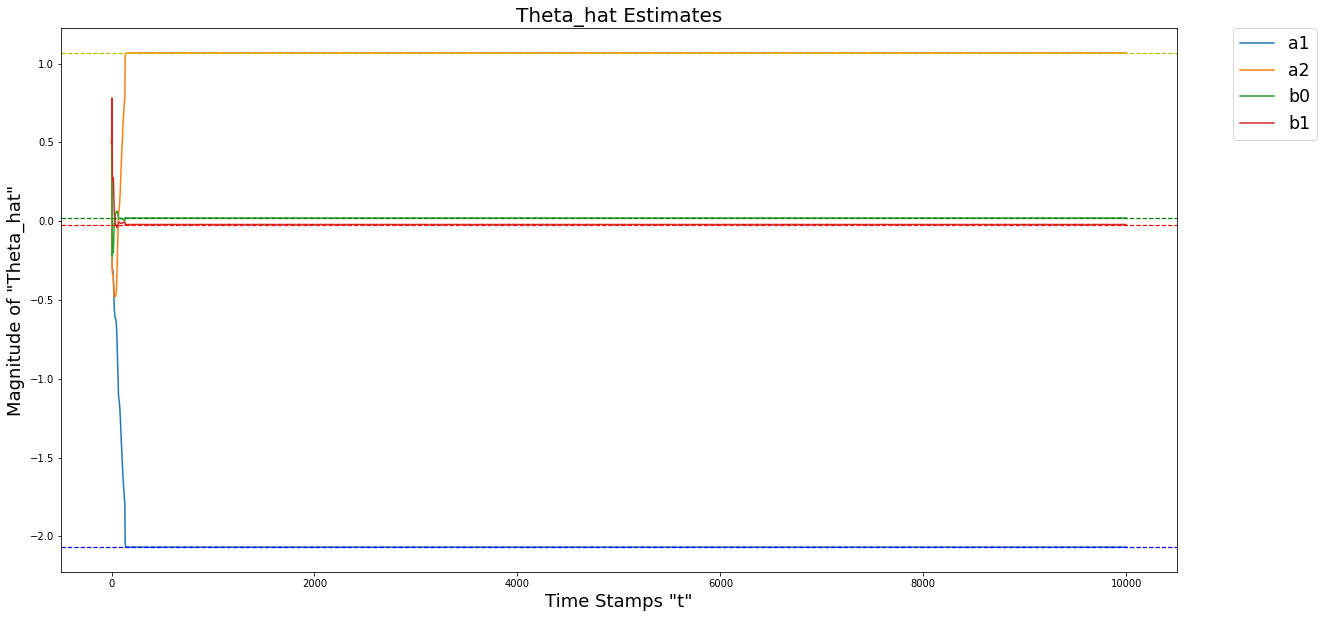

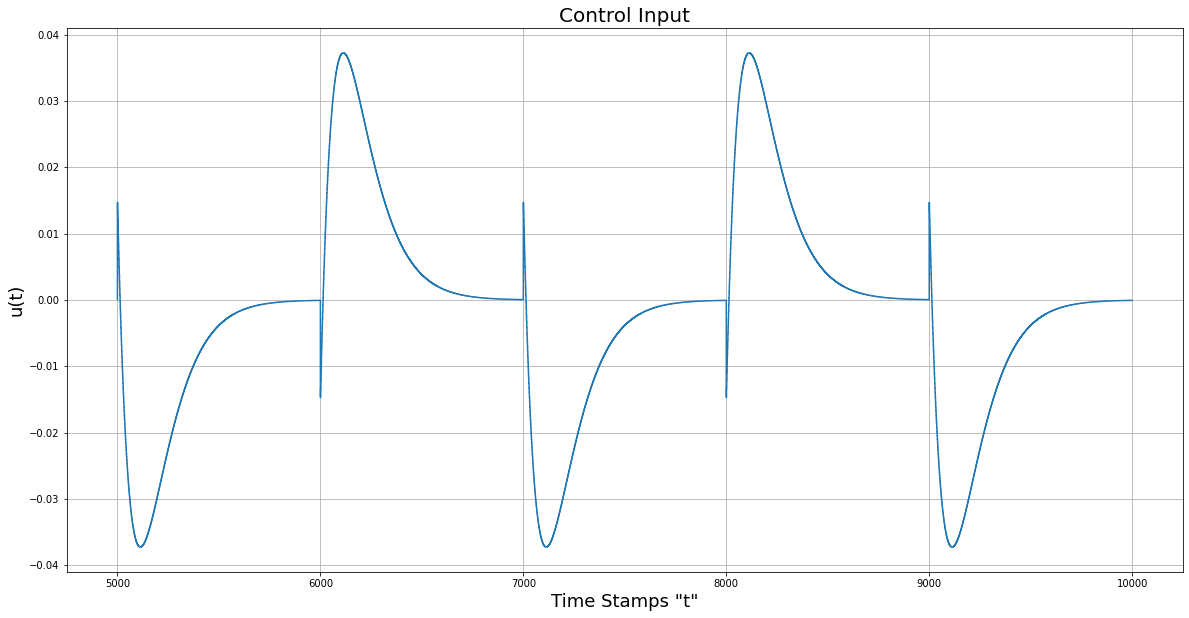

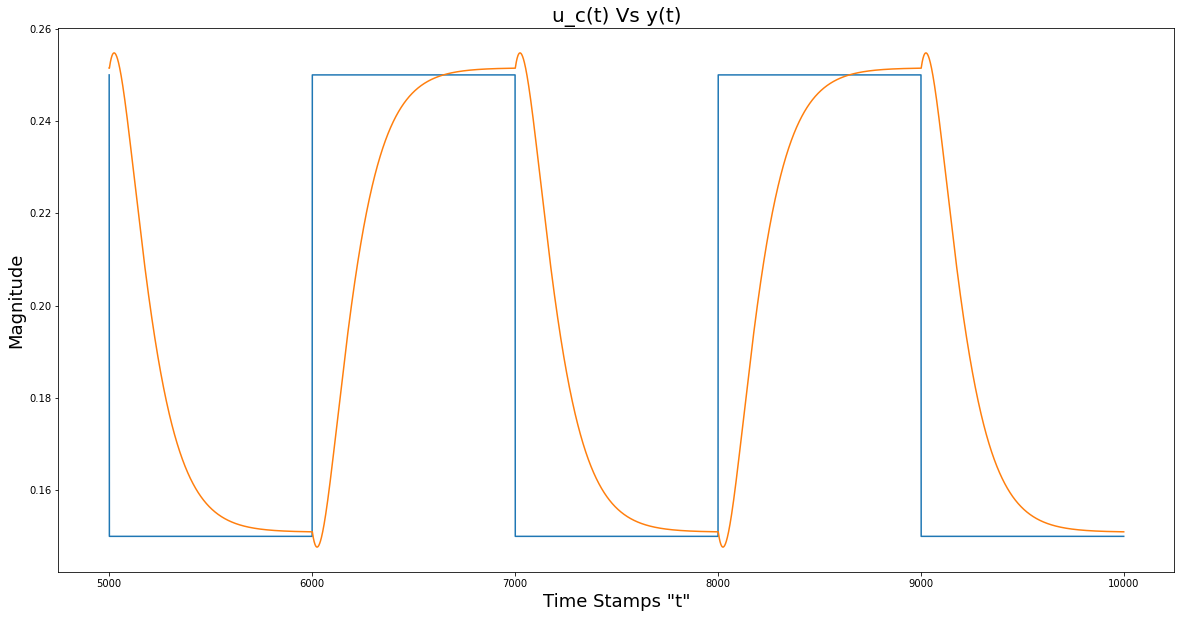

In [125]:
# Tunable components vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
sample_depth = 10000
starting_samples = 2

# starting estimate for plant parameters
est = 0.5

lam = 1 # forgeting factor lambda

# true plant parameters
theta0 = np.array([a1_val, a2_val, b0_val, b1_val]).reshape(-1,1)

# Tunable components ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

theta_hat = [np.array([est]*len(theta0)).reshape(-1,1) for _ in range(starting_samples)]

# System input TODO*********************************************************
sample_range = range(sample_depth)
t = [i for i in sample_range]
u_c = np.ones(sample_depth)*.25
u_c[np.where([m.sin(t[i]*m.pi/1000)<=0 for i in sample_range])] = 0.15

y = [0.1]*starting_samples
u = [0.1]*starting_samples

I = np.identity(len(theta0))
p = 100*I 
p_res = []
    
for k in range(starting_samples ,sample_depth):
    phi = np.array([-y[-1], -y[-2], u[-1], u[-2]]).reshape(-1,1)
    
    y.append(np.reshape(phi.T@theta0, ()))
    K = p@phi@inv(lam + phi.T@p@phi)
    p = (I - K@phi.T)@p/lam
    p_res.append(p)
    theta_hat.append(theta_hat[-1] + K*(y[k] - phi.T@theta_hat[-1]))
    
      
    u.append(np.reshape(uk_func(u[k-1], u_c[k], y[k], y[k-1], 
                                theta_hat[-1][0], theta_hat[-1][1], 
                                theta_hat[-1][2], theta_hat[-1][3])[0], ()))


# ploting of estimated parameters
df_theta = pd.DataFrame(np.asarray(theta_hat).reshape(-1,4,), columns=['a1', 'a2', 'b0', 'b1'])
theta_hat_ploter(df_theta, theta0, 'Theta_hat Estimates')

# ploting of control sig
plt.step(t[-5000:],u[-5000:])
plt.title('Control Input', fontsize=20)
plt.ylabel('u(t)', fontsize=18)
plt.xlabel('Time Stamps "t"', fontsize=18)
plt.grid()
plt.show()

# ploting of input vs output
plt.plot(t[-5000:],u_c[-5000:])
plt.plot(t[-5000:],y[-5000:])
plt.title('u_c(t) Vs y(t)', fontsize=20)
plt.ylabel('Magnitude', fontsize=18)
plt.xlabel('Time Stamps "t"', fontsize=18)
plt.show()


In [75]:
b0_val

0.020336564548018576

In [76]:
out = [idx for idx, value in enumerate(p_res) if (np.isnan(value) == True).any()]
# p_res[-1][0][0] = 1
# p_res[-1]
# display((np.isnan(p_res[-1]) == True).any())
# display(p_res[316])
print(out)

[]
